In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt 
import scipy.stats as stt
import itertools
import emcee

In [7]:
def model(params, t):
    amp, freq, phase, tau = params
    # amp, freq, phase, offset, tau = params
    return amp * np.cos(freq * 2 * np.pi * t + phase) * np.exp(- t / tau)# + offset


def cost(params, t, y):
    return ((model(params, t) - y)**2).sum()


def clean_raw_data(raw, init_cut=500, hit_cut=300, valid_duration=1500):
    """
        Clean raw data
        =====
        raw: raw data taken from experiment
        init cut: remove the amount of data points since start of collection
        hit cut: remove the amount of data since the hammer hit
        valid duration: retained number of data points immediately after the hit cut
    """
    tmp_data = raw[init_cut:]    
    hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
    selected_seg = tmp_data[hit_ind + hit_cut:hit_ind + hit_cut + valid_duration]
    return selected_seg


def reduce_segment(data, target_col=1):
    """
        Reduce data segment by removing takes due to higher samply rate of python
        than the accelerometer
        =====
        data: data to be reduced 
        target_col: column used for identify repeating takes
    """
    reduce_target = data[:, target_col]
    const_split = np.split(data, np.where(np.diff(reduce_target) != 0)[0] + 1)
    reduced_data = np.concatenate([tmp[:1] for tmp in const_split], axis=0)
    return reduced_data


def rms(data:np.ndarray):
    """
    Calculate the rms for an array
    """
    data = data - data.mean()
    return ((data**2).sum() / data.shape[0])**0.5


def log_prior(theta):
    # amp, freq, phase, offset, tau = theta
    amp, freq, phase, tau = theta
    # if (50 < amp < 150) and (9. < freq < 11.) and (0 < phase < 2 * np.pi) and (-20. < offset < 20.) and (0. < tau < 1.):
    if (50 < amp < 150) and (8. < freq < 12.) and (0 < phase < 2 * np.pi) and (0. < tau < 1.):
        return 0
    return -np.inf


def log_likelihood(theta, t, y):
    model_y = model(theta, t)
    return -0.5 * np.sum((model_y - y)**2 / (5 * np.exp(-t / 0.6))**2) # careful on the choice of rms


def log_prob(theta, t, y):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta, t, y)

In [8]:
configs = [1, 2, 3, 4, 5, 6, 8]
takes = [1, 2, 3]
axes_color = ['red', 'blue']
y_col = [1, 2]
fname = "../data/norm_mode_null_test/NullTest_config{}-{}-take{}.npy"
# tmp_data = np.load(f"../data/norm_mode_null_test/NullTest_config{config_no}-{ax_no}-take{take_no}.npy")[500:]

In [9]:
# enum = 0
for conf_no, axis, take_no in itertools.product(configs, axes_color, takes):
    # if conf_no != 3:
    #     continue
    print(conf_no, axis, take_no)
    raw_data = np.load(fname.format(conf_no, axis, take_no))
    selected_raw = clean_raw_data(raw_data)
    data = reduce_segment(selected_raw)
    t = data[:, 0] - data[0, 0]
    plt.figure(dpi=300)
    plt.title(f"config-{conf_no} axis-{axis} take-{take_no}")

    for col in y_col:
        y = data[:, col] - data[:, col].mean()
        # guess = np.array((np.abs(y).max(), 10.5, 1., y.mean(), 0.6))
        guess = np.array((np.abs(y).max(), 10.2, 1., 0.6))
        # if col == 2:
        #     guess = np.array((np.abs(y).max(), 10., 1., 0.6))
        pos = guess + np.random.randn(16, *guess.shape) * np.abs(guess) / 100
        nwalker, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalker, ndim, log_prob, args=(t, y))
        sampler.run_mcmc(pos, 40000, progress=True)
        flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
        fit_mean = flat_samples.mean(axis=0)
        fit_std = flat_samples.std(axis=0)
        print(fit_mean)
        print(fit_std)
        ################
        # res = opt.minimize(cost, (1000, 10, 0.1, -50, 0.1), (t, y))
        # print(res.x)
        plt.plot(t, y, label=f"raw {col}")
        plt.plot(t, model(fit_mean, t), label=f"fit {col}")
        ################
        # break
    plt.legend()
    # if enum >= 5:
    #     break
    # enum += 1
    

You must install the tqdm library to use progress indicators with emcee


1 red 1


You must install the tqdm library to use progress indicators with emcee


[8.18720256e+01 1.03910918e+01 1.40524548e-04 6.69030470e-01]
[5.71397752e-01 5.86903845e-04 1.39032926e-04 3.39179743e-03]


You must install the tqdm library to use progress indicators with emcee


[50.03137737 10.38585395  3.28011694  0.37757266]
[0.03158404 0.00439951 0.01820651 0.00320871]
1 red 2


You must install the tqdm library to use progress indicators with emcee


[82.65868996 10.37278385  2.00326329  0.64900732]
[5.29103764 0.32009351 0.5168857  0.16756383]


You must install the tqdm library to use progress indicators with emcee


[65.48867257 10.17358879  0.63442519  0.24273418]
[26.38053279  0.73037178  0.81964969  0.18735546]
1 red 3


You must install the tqdm library to use progress indicators with emcee


[82.86616142 10.05749429  1.42483418  0.62948635]
[15.79592361  0.80048135  0.32664331  0.11191433]


You must install the tqdm library to use progress indicators with emcee


[60.82035419 10.82660876  3.5765014   0.33602078]
[25.43528072  0.60943024  0.63694646  0.14138259]
1 blue 1


You must install the tqdm library to use progress indicators with emcee


[66.7194902  10.49912463  1.69999361  0.60884936]
[9.1386305  0.49884754 0.18482572 0.14410466]


You must install the tqdm library to use progress indicators with emcee


[243.15480879  10.17762657   1.00483133   0.60058316]
[2.37820999 0.09697539 0.00990593 0.00434291]
1 blue 2


You must install the tqdm library to use progress indicators with emcee


[43.61971925 10.19932234  0.99891025  0.60124702]
[0.4919885  0.07603196 0.01051846 0.00638065]


You must install the tqdm library to use progress indicators with emcee


[248.64585449  10.19962187   0.9978139    0.60273627]
[1.41115964 0.0799175  0.01035552 0.00396976]
1 blue 3


You must install the tqdm library to use progress indicators with emcee


[50.11369978 10.62880594  1.48195222  0.63993732]
[0.15484116 0.22013939 0.10138492 0.18922832]


You must install the tqdm library to use progress indicators with emcee


[253.42590275  10.18007075   1.00251011   0.59687345]
[2.14312308 0.08926927 0.00894205 0.00793196]
2 red 1


You must install the tqdm library to use progress indicators with emcee


[36.53496869 10.22526969  1.00557186  0.60001766]
[0.46409337 0.07375672 0.00711524 0.00676443]


You must install the tqdm library to use progress indicators with emcee


[77.50721144 10.37770535  0.09635166  0.7719218 ]
[18.72261895  0.45753688  0.3727837   0.15444799]
2 red 2


You must install the tqdm library to use progress indicators with emcee


[37.27250241 10.17773458  1.00004324  0.59945911]
[0.28830363 0.11331707 0.01068467 0.00629769]


You must install the tqdm library to use progress indicators with emcee


[5.65354072e+01 1.03254031e+01 4.13646429e-05 9.11377092e-01]
[4.97778044e-01 5.58072492e-04 4.09109169e-05 7.03420531e-03]
2 red 3


You must install the tqdm library to use progress indicators with emcee


[1.04835258e+02 1.02326523e+01 1.63308844e+00 1.80411833e-03]
[2.92451993e+01 1.15459498e+00 5.97892070e-02 4.84635482e-04]


You must install the tqdm library to use progress indicators with emcee


[6.27923731e+01 1.02895372e+01 2.68745087e-05 9.71476031e-01]
[5.06520530e-01 4.70619612e-04 2.68836768e-05 7.30345635e-03]
2 blue 1


You must install the tqdm library to use progress indicators with emcee


[136.4987754   11.02608442   0.44892438   0.7835255 ]
[0.52344274 0.00061316 0.00369959 0.00242018]


You must install the tqdm library to use progress indicators with emcee


[47.67815006 10.18586495  0.99912926  0.60042057]
[0.38571272 0.08345356 0.01453247 0.00627271]
2 blue 2


You must install the tqdm library to use progress indicators with emcee


[176.78869137  10.17358645   1.00036074   0.59946974]
[1.8347635  0.10793806 0.00771964 0.00582674]


You must install the tqdm library to use progress indicators with emcee


[5.00046066e+01 1.01835048e+01 2.16870012e-02 7.90520467e-01]
[0.0050377  0.82511913 0.05722836 0.18019153]
2 blue 3


You must install the tqdm library to use progress indicators with emcee


[173.33182944  10.21296751   0.99928369   0.59962627]
[1.70907905 0.07639445 0.00637396 0.00538724]


You must install the tqdm library to use progress indicators with emcee


[5.00072318e+01 1.04548915e+01 7.08160172e-05 7.48595473e-01]
[7.27454955e-03 7.92471890e-04 7.12232416e-05 2.77044670e-03]
3 red 1


You must install the tqdm library to use progress indicators with emcee


[104.50056118  10.25366894   2.02520372   0.68294707]
[0.55669741 0.00092626 0.00535168 0.00265601]


You must install the tqdm library to use progress indicators with emcee


[5.00119589e+01 1.01348638e+01 2.32146490e-04 5.41180768e-01]
[0.0120104  0.00131558 0.00023182 0.00274419]
3 red 2


You must install the tqdm library to use progress indicators with emcee


[128.40247437  10.22576462   1.76257428   0.66299881]
[0.57134988 0.00078164 0.00443058 0.00213616]


You must install the tqdm library to use progress indicators with emcee


[5.00183530e+01 1.00172731e+01 2.79964897e-04 4.39021398e-01]
[0.01840206 0.00210165 0.00028094 0.00288998]
3 red 3


You must install the tqdm library to use progress indicators with emcee


[123.93132273  10.23580513   1.63263667   0.67462808]
[0.56384095 0.00077365 0.00447445 0.00223705]


You must install the tqdm library to use progress indicators with emcee


[8.67995334e+01 9.88004473e+00 1.88501831e+00 1.10391630e-02]
[29.22919013  1.22068165  0.23204247  0.03905903]
3 blue 1


You must install the tqdm library to use progress indicators with emcee


[50.12750872 11.11086706  0.94930342  0.4627592 ]
[0.12527369 0.00334873 0.0146625  0.00312625]


You must install the tqdm library to use progress indicators with emcee


[244.15201618  10.17010825   1.00141383   0.59746046]
[2.48590727 0.09115656 0.01044196 0.00605469]
3 blue 2


You must install the tqdm library to use progress indicators with emcee


[5.00547479e+01 1.10454362e+01 9.24190849e-04 4.82952884e-01]
[0.05485905 0.00176013 0.00091917 0.00273759]


You must install the tqdm library to use progress indicators with emcee


[214.26926555  10.19627904   0.99868843   0.60029801]
[2.26248831 0.09245004 0.01010124 0.00538594]
3 blue 3


You must install the tqdm library to use progress indicators with emcee


[50.8746191  10.90043111  0.55363737  0.45680999]
[0.66846765 0.69384199 0.15628691 0.00649723]


You must install the tqdm library to use progress indicators with emcee


[225.07378676  10.1889974    0.99543829   0.6037843 ]
[2.14662789 0.10317099 0.00935082 0.00458951]
4 red 1


You must install the tqdm library to use progress indicators with emcee


[160.88131135  10.20279538   1.00536132   0.60209322]
[1.29395913 0.06948803 0.00856943 0.00633506]


You must install the tqdm library to use progress indicators with emcee


[54.16234779 10.04902681  0.15910744  0.33127025]
[11.18385673  0.61846007  0.42067542  0.1242306 ]
4 red 2


You must install the tqdm library to use progress indicators with emcee


[163.69862276  10.2141374    1.000965     0.59970742]
[1.53667147 0.0676428  0.00944752 0.00407611]


/var/folders/zk/5n1qblpn7gx5p2lmvqcwhny40000gn/T/ipykernel_98880/2650083564.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=300)
You must install the tqdm library to use progress indicators with emcee


[54.48032486 10.21940118  0.09267188  0.37676205]
[17.26799971  0.07705478  0.35774565  0.09721869]
4 red 3


You must install the tqdm library to use progress indicators with emcee


[159.48248729  10.16261167   0.99850922   0.59856572]
[1.55012292 0.12644842 0.01260441 0.00741329]


You must install the tqdm library to use progress indicators with emcee


[60.59838962 10.51926778  3.2669334   0.39684247]
[17.51154467  0.65311488  1.49627022  0.19250257]
4 blue 1


You must install the tqdm library to use progress indicators with emcee


[51.94675978 10.6076362   0.50908536  0.81356452]
[0.54041763 0.13353908 0.04657121 0.18096205]


You must install the tqdm library to use progress indicators with emcee


[226.38886871  10.18370793   0.99994212   0.60136851]
[2.08482365 0.08422691 0.00922506 0.00658369]
4 blue 2


You must install the tqdm library to use progress indicators with emcee


[61.69314539 10.5742905   0.8619305   0.78580172]
[0.84033884 0.16605794 0.12138602 0.16240937]


You must install the tqdm library to use progress indicators with emcee


[185.50747155  10.18008999   1.00212679   0.60033194]
[1.8298143  0.11181968 0.00919649 0.00559062]
4 blue 3


You must install the tqdm library to use progress indicators with emcee


[52.98180903 10.14297126  0.93376223  0.73833866]
[11.21218674  1.02714488  1.03151992  0.33126257]


You must install the tqdm library to use progress indicators with emcee


[223.51634043  10.23249499   0.99841745   0.60137838]
[1.83291391 0.09521259 0.00705479 0.00517871]
5 red 1


You must install the tqdm library to use progress indicators with emcee


[114.79319994  10.26996516   1.55782455   0.70549395]
[0.55734924 0.00082736 0.00484282 0.00256246]


You must install the tqdm library to use progress indicators with emcee


[50.96760635 10.17663888  0.77236936  0.50360479]
[2.94565918 0.44777256 1.35089302 0.05460514]
5 red 2


You must install the tqdm library to use progress indicators with emcee


[89.42661202 10.1681427   1.33040341  0.71349543]
[0.80431849 0.51238788 0.10070384 0.04974084]


You must install the tqdm library to use progress indicators with emcee


[1.19395655e+02 1.06290670e+01 1.78455763e+00 3.04667225e-03]
[2.51795984e+01 1.05415661e+00 8.86418360e-02 3.65257044e-04]
5 red 3


You must install the tqdm library to use progress indicators with emcee


[118.34110996  10.25473821   1.57224855   0.68833356]
[0.56606248 0.00081785 0.00475356 0.00240381]


You must install the tqdm library to use progress indicators with emcee


[52.08488443 10.02164747  0.06245662  0.4816536 ]
[8.01953922 0.32058281 0.2412149  0.02662781]
5 blue 1


You must install the tqdm library to use progress indicators with emcee


[61.1943753  10.48022477  0.97816874  0.67910522]
[2.7843983  0.20443673 0.01803624 0.15115868]


You must install the tqdm library to use progress indicators with emcee


[205.80040523  10.25014911   1.00198776   0.60210652]
[2.55075759 0.10183725 0.01057289 0.006556  ]
5 blue 2


You must install the tqdm library to use progress indicators with emcee


[5.00074186e+01 1.01568397e+01 7.34230392e-05 6.91845627e-01]
[7.49910908e-03 8.85954987e-04 7.35590995e-05 2.73565304e-03]


You must install the tqdm library to use progress indicators with emcee


[178.95235177  10.1979728    0.99777506   0.60006901]
[1.9759696  0.07659445 0.01000424 0.00469366]
5 blue 3


You must install the tqdm library to use progress indicators with emcee


[65.41961044 10.49102853  0.11223074  0.75069295]
[0.50309788 0.00143752 0.00863977 0.00439876]


You must install the tqdm library to use progress indicators with emcee


[237.39278482  10.21528921   0.99927132   0.59984938]
[2.6378569  0.10254691 0.0107481  0.00464402]
6 red 1


You must install the tqdm library to use progress indicators with emcee


[121.98998864  10.27817992   1.82679491   0.69377531]
[0.55893931 0.0007546  0.00443476 0.00237059]


You must install the tqdm library to use progress indicators with emcee


[50.10744554 10.09908174  1.68048929  0.32888181]
[0.59769274 0.09763921 2.49188028 0.01721886]
6 red 2


You must install the tqdm library to use progress indicators with emcee


[119.33562803  10.27971053   2.05846286   0.68643723]
[0.56140736 0.00081676 0.00469965 0.00246229]


You must install the tqdm library to use progress indicators with emcee


[5.00288770e+01 1.01314856e+01 5.79118990e-04 3.45392718e-01]
[0.02896437 0.00359856 0.00057788 0.00354174]
6 red 3


In [84]:
fit_theta

array([19.43287481,  0.5341084 ,  0.40465228,  0.68067776,  0.62097539])

Text(0.5, 0, 'step number')

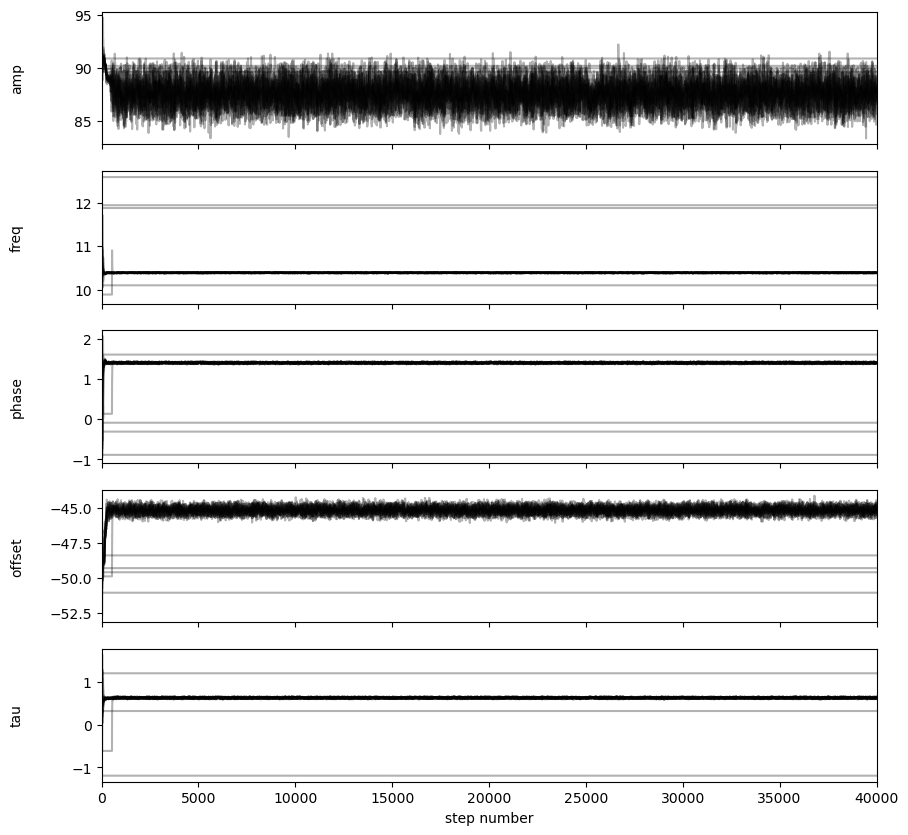

In [58]:
fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["amp", "freq", "phase", "offset", "tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [59]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan  1. nan nan]


In [62]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(41600, 5)


In [63]:
flat_samples.mean(axis=0)

array([ 88.24011441,  10.69721394,   1.06845863, -46.28357515,
         0.52561874])

In [64]:
flat_samples.std(axis=0)


array([1.42003362, 0.70625862, 0.73582942, 1.98673183, 0.47173579])

In [119]:
hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
cut_seg = 300
valid_seg = 1500
start = hit_ind + cut_seg
end = start + valid_seg
selected_seg = tmp_data[start:end]

In [120]:
fit_ax = 2
test_data = selected_seg[:, fit_ax]
const_split = np.split(selected_seg, np.where(np.diff(test_data) != 0)[0] + 1)
clean_seg = np.concatenate([tmp[:1] for tmp in const_split], axis=0)
t = clean_seg[:, 0]
y = clean_seg[:, fit_ax]
res = opt.minimize(cost, (1000, 10, 0.1, -50, 0.1), (t, y))

In [106]:
res.x

array([328.3747727 ,  10.38829199,  -1.85446778, -45.17561341,
         0.62058275])

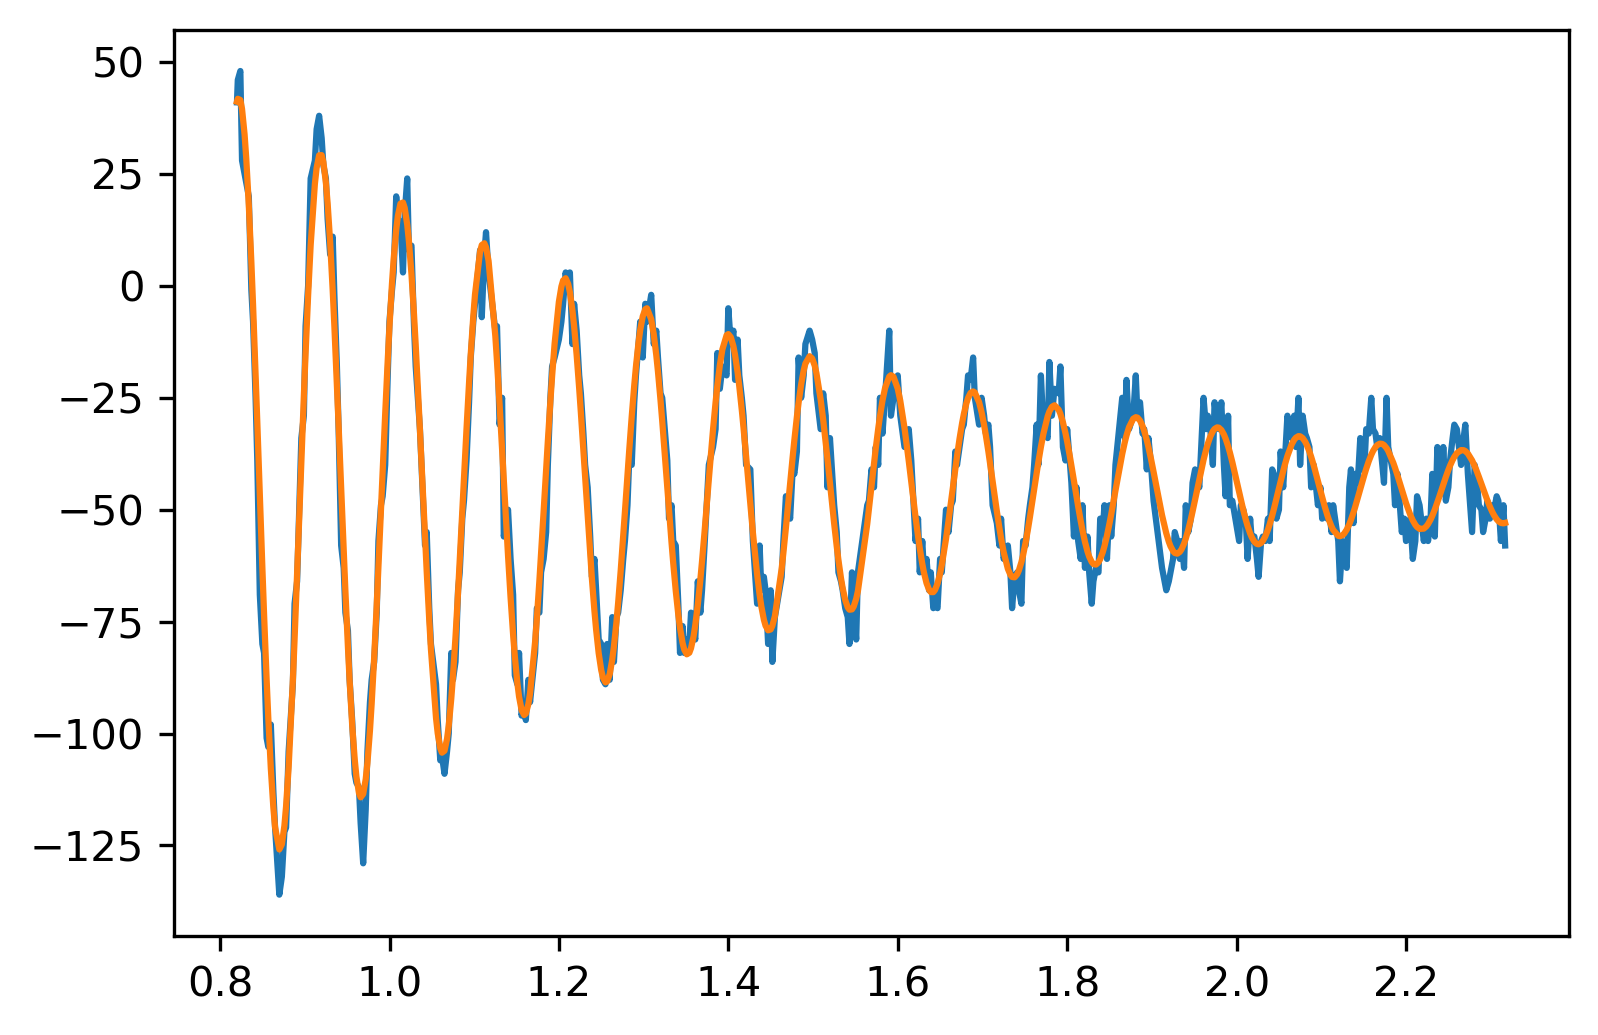

In [105]:
plt.figure(dpi=300)
plt.plot(t, y)
plt.plot(t, model(res.x, t))

In [121]:
y_bar = np.fft.fft(y - y.mean())
freqs = np.fft.fftfreq(y.shape[0], 1/400)

In [122]:
def gaussian(params, x):
    amp, sigma, loc, shift = params
    return amp * np.exp(- (x - loc)**2 / 2 / sigma**2) + shift

def gauss_cost(params, x, y):
    model = gaussian(params, x)
    return ((y - model)**2).sum()

In [123]:
data_mask = (freqs > 0) * (freqs < 30)
y = np.abs(y_bar[data_mask])
x = freqs[data_mask]
guess = (4000, 1, 10.7, 100)
res = opt.minimize(gauss_cost, guess, (x, y))

In [117]:
res.x

array([5.84584108e+03, 1.84860564e+00, 9.95256136e+00, 1.79982016e+04])

In [124]:
res.x

array([9.34137318e+03, 9.94254068e-01, 1.13823737e+01, 7.09279528e+02])

(0.0, 30.0)

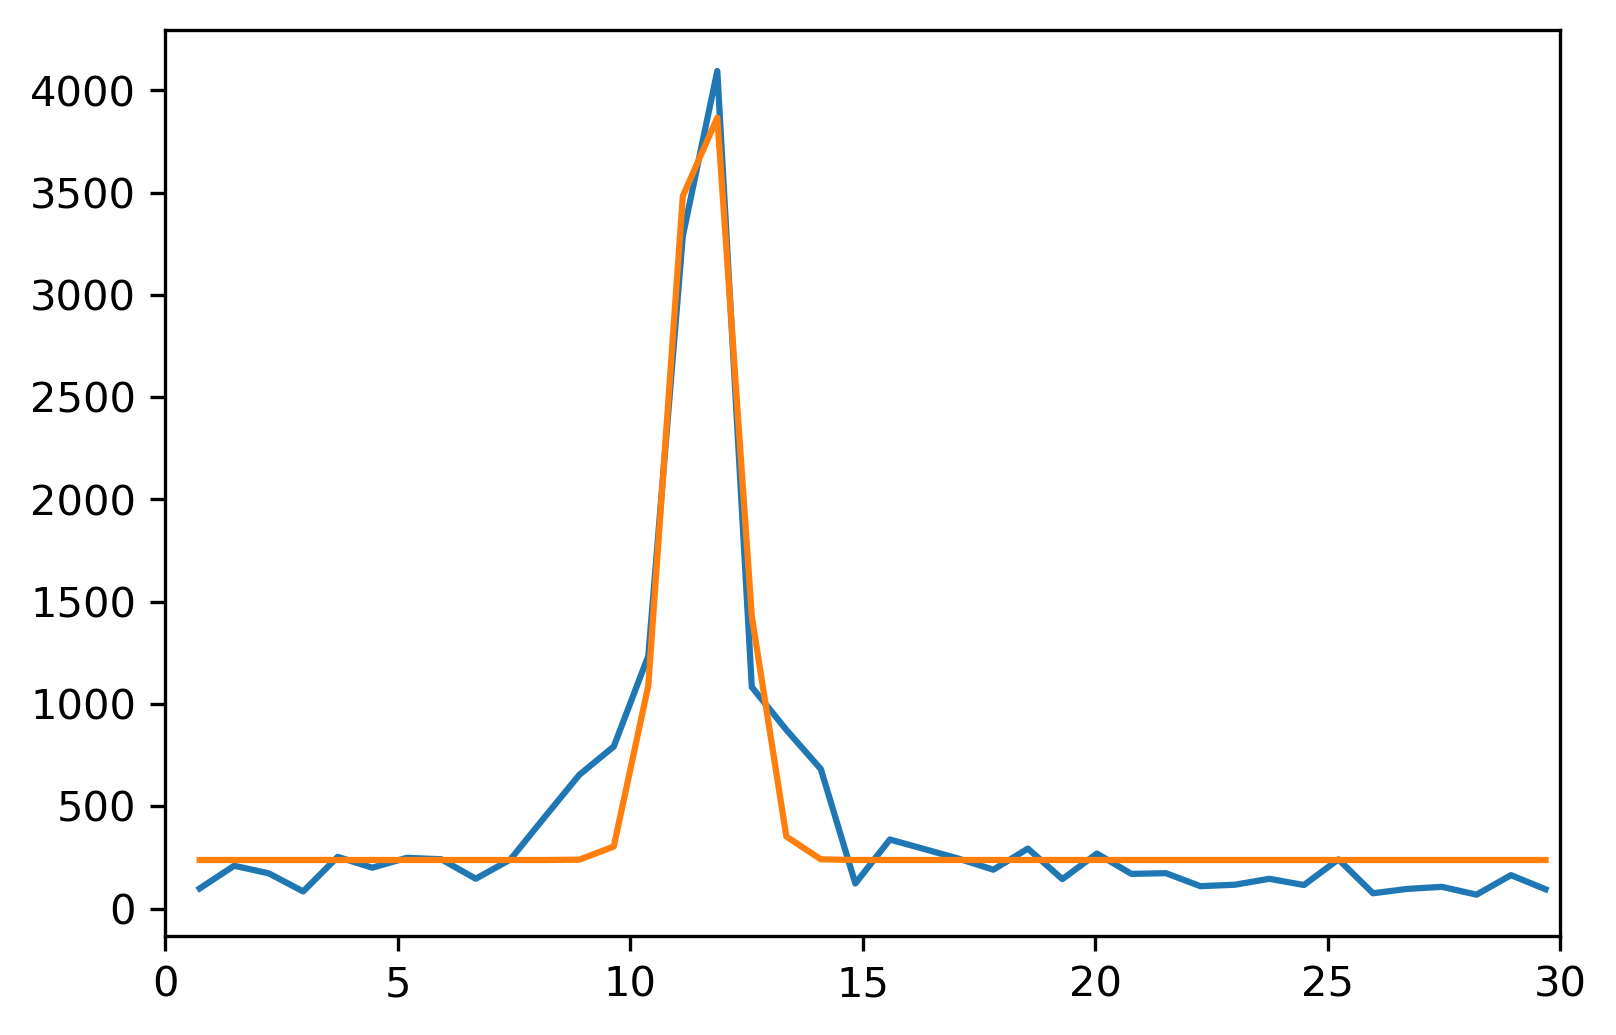

In [87]:
plt.figure(dpi=300)
# plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(y_bar)))
plt.plot(x, y)
plt.plot(x, gaussian(res.x, x))
plt.xlim(0, 30)

In [49]:
freqs[np.argmax(np.abs(y_bar))]


11.873840445269018

In [36]:
res.x

array([132.45411066,  10.65977996,  -4.51185737, -44.89138648,
         1.03698997])

In [27]:
res.x

array([326.84684787,  10.54601147,  -5.86263996, -44.65519918,
         0.81457903])

In [37]:
np.diag(res.hess_inv) ** 0.5

array([0.01022382, 0.00053474, 0.00772065, 0.01704966, 0.00228248])

In [32]:
null_data = np.load(f"../data/norm_mode_null_test/NullTest_no_hit_take2.npy")[500:]

In [33]:
test_data = null_data[:, 2]
const_split = np.split(null_data, np.where(np.diff(test_data) != 0)[0] + 1)
clean_seg = np.concatenate([tmp[:1] for tmp in const_split], axis=0)

In [34]:
rms(clean_seg[:, 1])

4.978750455003622

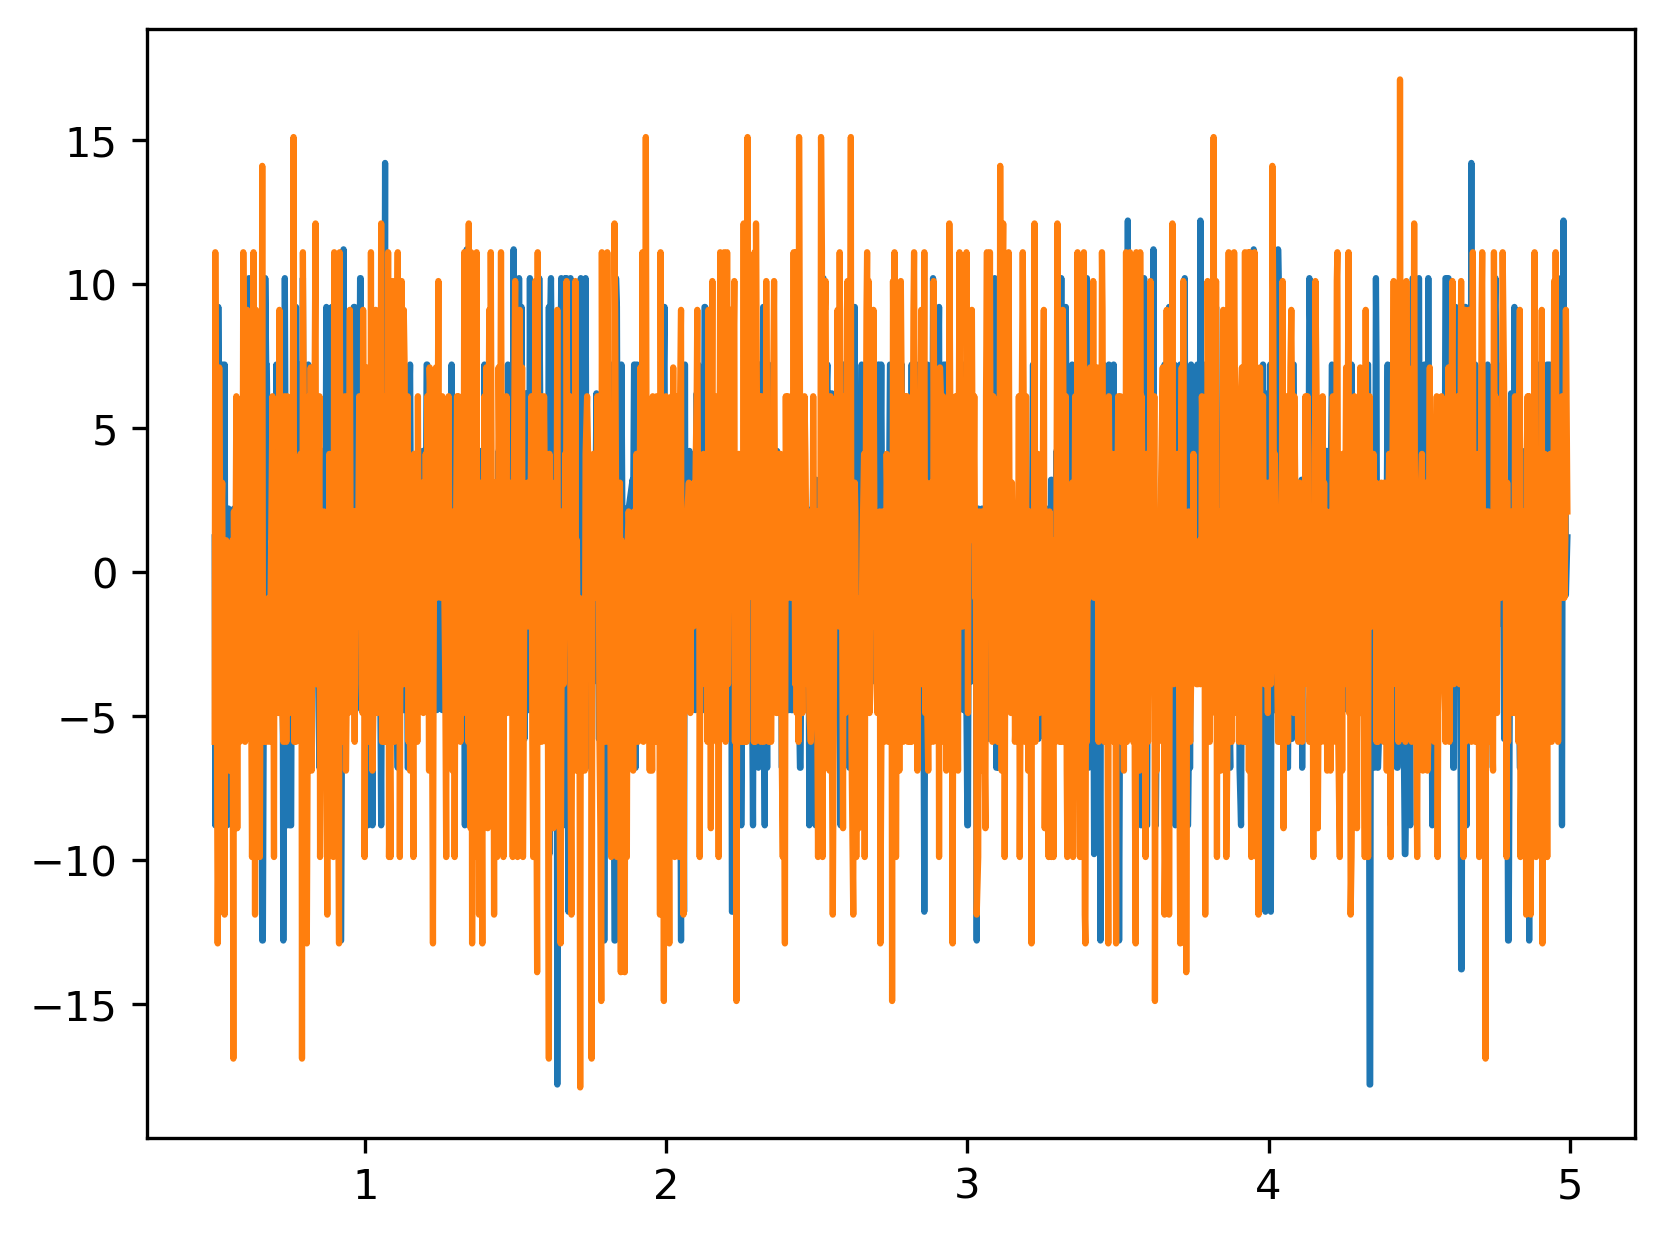

In [35]:
plt.figure(dpi=300)
plt.plot(clean_seg[:, 0], clean_seg[:, 1] - clean_seg[:, 1].mean())
plt.plot(clean_seg[:, 0], clean_seg[:, 2] - clean_seg[:, 2].mean())
# plt.plot(t, model(res.x, t))

In [21]:
rms(clean_seg[:, 1])

5.248181831953594

(0.0, 400000.0)

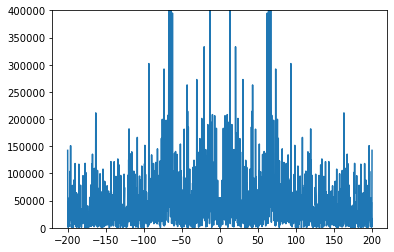

In [106]:
ps = np.abs(np.fft.fft(clean_seg[:, 1] - clean_seg[:, 1].mean()))**2
freqs = np.fft.fftfreq(clean_seg.shape[0], 1/400)
idx = np.argsort(freqs)
plt.plot(freqs[idx], ps[idx])
plt.ylim(0, 4e5)

(array([2.97420887e+05, 1.49394023e+05, 1.84761797e+01, 3.18216527e+01,
        3.67328893e+01, 4.03567240e+01, 3.29560709e+01, 2.13869962e+01,
        5.76798790e+01, 6.47455981e+01, 3.05064151e+01, 2.36198760e+01,
        2.87236189e+01, 5.36229494e+01, 4.36268188e+01, 3.05148888e+01,
        1.71469759e+01, 2.28592951e+01, 2.06109955e+01, 2.17998659e+01,
        1.05665629e+01, 1.47465850e+01, 2.31471039e+01, 1.77508953e+01,
        3.25094690e+00, 2.37671798e+01, 3.27783952e+01, 4.29195521e+01,
        1.72168496e+01, 1.54483995e+01, 2.17074440e+01, 2.03665955e+01,
        2.21851417e+01, 2.36010517e+01, 1.35971803e+01, 1.57584428e+01,
        3.52066799e+01, 5.56714229e+01, 4.74290503e+01, 4.26651913e+01,
        7.63664929e+01, 8.02467427e+01, 1.24776155e+02, 1.17421293e+02,
        5.40782066e+01, 2.14271371e+01, 2.54027300e+01, 5.07114297e+01,
        5.67439464e+01, 4.62388638e+01, 1.30875423e+01, 1.58087672e+01,
        1.93842477e+01, 2.46293766e+01, 2.41046547e+01, 1.747526

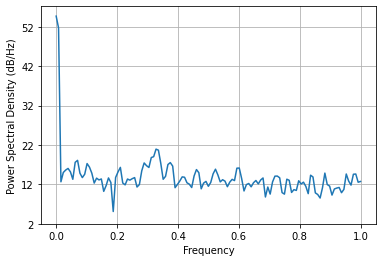

In [107]:
plt.psd(clean_seg[:, 1])

In [126]:
config_no = 1
take_no = 1
ax_dict = {'red':1 , 'blue':2}
for color in ('red', 'blue'):
    tmp_data = np.load(f"../data/norm_mode_null_test/NullTest_config{config_no}-{ax_no}-take{take_no}.npy")[500:]
    hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
    cut_seg = 300
    valid_seg = 1500
    start = hit_ind + cut_seg
    end = start + valid_seg
    selected_seg = tmp_data[start:end]

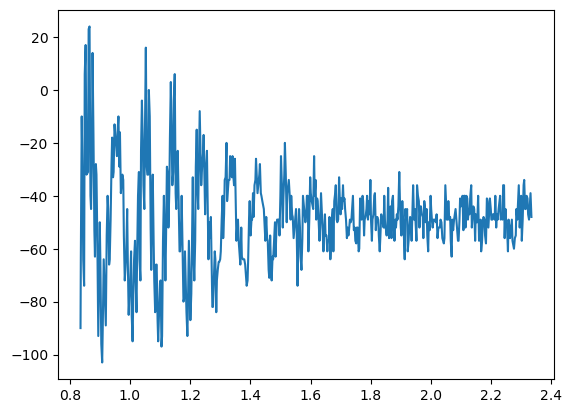

In [15]:
plt.plot(t, y)